In [1]:
import cdpm
from cdpm import CondDirichletProcessMix
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import tqdm
import pandas as pd
import seaborn.apionly as sns
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from matplotlib import cm, pyplot as pltf

In [2]:
%matplotlib inline
plt.style.use(['seaborn-dark-palette', 'seaborn-poster'])

In [3]:
#np.random.seed(424) # 10037

In [4]:
num_draws = 3000

In [5]:
time_dim = 250
stick_scale = 2
beta_mu, beta_sigma = .9, 0.1 # mean and standard deviation
precn_df, precn_scale = 100, 1

In [6]:
cluster_series, alpha_series, beta_mat, precn_mat, sticks_vec = cdpm.simulate_cdpm(time_dim, beta_mu=beta_mu, beta_sigma=beta_sigma,
                                                                       precn_df=precn_df,precn_scale=precn_scale, 
                                                                       stick_scale=stick_scale)

In [7]:
sticks_vec

array([ 0.54196659,  0.28510416,  0.77345174,  0.24904632,  0.19872136,
        0.59323371,  0.34203404,  0.63037495,  0.64923469])

In [8]:
cdpm.compute_probabilities(sticks_vec)

array([ 0.54196659,  0.13058723,  0.25326381,  0.01847484,  0.01107027,
        0.02648032,  0.00621029,  0.00753086,  0.00286688])

In [9]:
precn_mat**(-.5)

array([ 0.1065174 ,  0.11024182,  0.0989122 ,  0.11313333,  0.09592888,
        0.10161115,  0.09618136,  0.10295012,  0.10292833])

In [10]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'precn': {'scale': [precn_scale**(-1)], 'shape': [precn_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [11]:
mean_precn = np.asarray(precn_scale / (precn_df - 1))

In [12]:
# alpha_series = [0]
# for t in range(1, time_dim):
#     innovation = np.random.normal(0, .1)
#     alpha = alpha_series[t-1] + innovation 
#     if -1 < alpha < 1:
#         alpha_series.append(alpha)
#     else:
#         alpha_series.append(-.5 * alpha_series[t-1] + innovation)
    

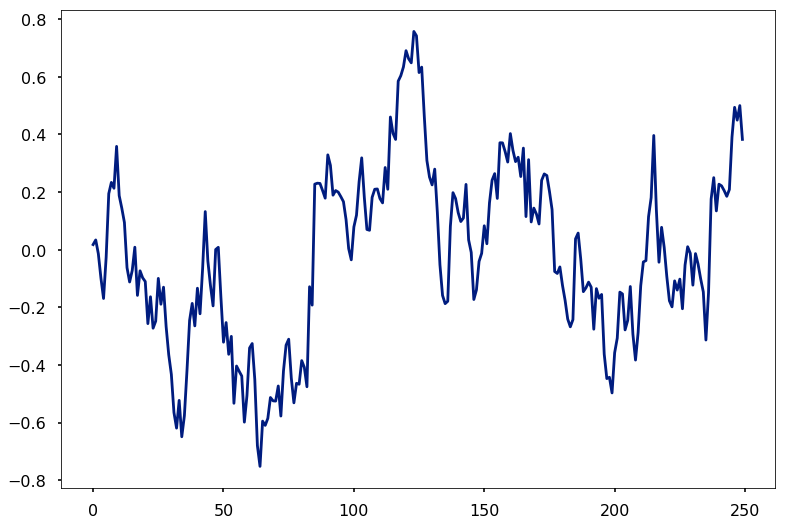

In [13]:
plt.plot(alpha_series)

In [14]:
## Initialization
model = CondDirichletProcessMix(beta_mu, tau=mean_precn,regressor=alpha_series[:-1], regressand=alpha_series[1:])

## Estimation

In [15]:
cluster_identity_draws = np.empty((num_draws, time_dim-1))
stick_draws = np.full((num_draws, 50),np.nan)
beta_draws = np.full((num_draws, 50),np.nan)
precision_draws = np.full((num_draws, 50),np.nan)
trans_mat_draws = np.full((num_draws, 50, 50),np.nan)

In [16]:
for draw_idx in tqdm(range(num_draws)):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    stick_draws[draw_idx,:len(model_posterior[1])] = model_posterior[1]
    beta_draws[draw_idx,:len(model_posterior[2])] = np.squeeze(model_posterior[2]) 
    precision_draws[draw_idx,:len(model_posterior[3])] = model_posterior[3]
    trans_mat_draws[draw_idx,:model_posterior[4].shape[0], :model_posterior[4].shape[1]] = model_posterior[4]
    

100%|██████████| 3000/3000 [00:05<00:00, 523.74it/s]


## Simulation Results

In [35]:
percentiles = [.1, 1,5, 25, 50, 75, 95, 99, 99.9]

In [36]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

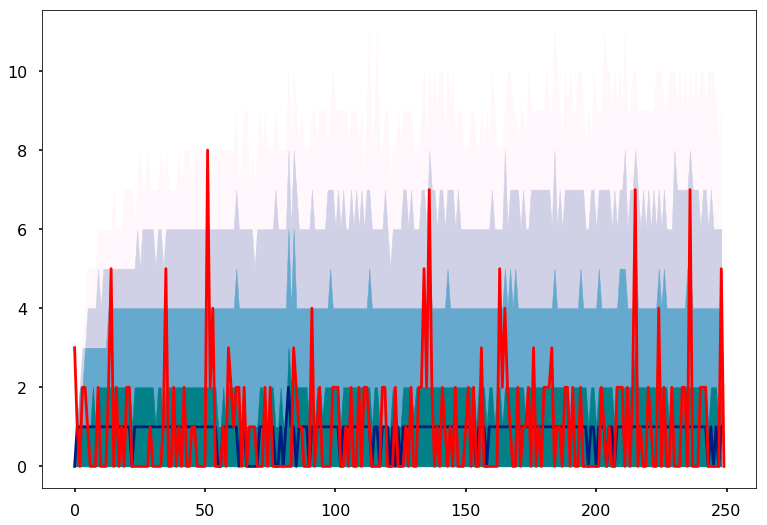

In [37]:
state_comparison_fig, state_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(state_comparison_ax, pd.DataFrame(cluster_identity_draws.T), percentiles)
state_comparison_ax.plot(cluster_series, c='red')

In [20]:
pd.DataFrame(beta_draws).mean().dropna()

0     0.932088
1     0.906837
2     0.884214
3     0.864506
4     0.875282
5     0.859223
6     0.838944
7     0.834804
8     0.822270
9     0.821858
10    0.757645
11    0.845885
12    0.885358
13    0.680906
dtype: float64

In [21]:
beta_mat

array([[[ 0.94454574]],

       [[ 0.99009901]],

       [[ 0.99009901]],

       [[ 0.5896017 ]],

       [[ 0.99009901]],

       [[ 0.93430419]],

       [[ 0.87249344]],

       [[ 0.79916207]],

       [[ 0.94430294]]])

In [22]:
pd.DataFrame(precision_draws**(-.5)).mean().dropna()

0     0.102341
1     0.101578
2     0.101170
3     0.100996
4     0.100670
5     0.100558
6     0.100539
7     0.100436
8     0.100781
9     0.100572
10    0.100460
11    0.099182
12    0.099927
13    0.098565
dtype: float64

In [23]:
precn_mat**(-.5)

array([ 0.1065174 ,  0.11024182,  0.0989122 ,  0.11313333,  0.09592888,
        0.10161115,  0.09618136,  0.10295012,  0.10292833])

In [24]:
pd.DataFrame(cdpm.compute_probabilities(pd.DataFrame(stick_draws).mean().dropna()))

0
0   0.606177
1   0.213507
2   0.088281
3   0.041959
4   0.020417
5   0.012356
6   0.007064
7   0.004160
8   0.002358
9   0.001396
10  0.000733
11  0.000595
12  0.000362
13  0.000204

In [25]:
cdpm.compute_probabilities(sticks_vec)

array([ 0.54196659,  0.13058723,  0.25326381,  0.01847484,  0.01107027,
        0.02648032,  0.00621029,  0.00753086,  0.00286688])

In [26]:
pd.DataFrame(np.mean(trans_mat_draws, axis=0)).iloc[0,0]

0.48053393873481814

## Get the dynamics of alpha given the estimated clusters/parameters

In [27]:
beta_est = np.array(pd.DataFrame(beta_draws).mean().dropna())
sigma_est = 1 / np.array(pd.DataFrame(precision_draws).mean().dropna())

In [28]:
alpha_est_mat = np.empty((time_dim-1, num_draws))
#alpha_est_mat[0] = np.zeros(num_draws)

In [29]:
for draw in tqdm(range(num_draws)):
    for t_idx in range(1, time_dim):
        cluster_identity = cluster_identity_draws[draw,t_idx-1].astype(int)
        cl_idx = np.argmax(np.random.multinomial(n=1,pvals=trans_mat_draws[draw][cluster_identity,:]).astype(np.bool))
        alpha_f = (alpha_series[t_idx-1] * beta_draws[draw, cl_idx] 
                   + precision_draws[draw, cl_idx]**(-.5) * np.random.normal(0,1, size=1))
        alpha_est_mat[t_idx-1, draw] = np.asscalar(alpha_f)

100%|██████████| 3000/3000 [00:12<00:00, 241.76it/s]


In [30]:
plt.rcParams['image.cmap'] = 'PuBuGn'

In [38]:
alpha_comparison_fig, alpha_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(alpha_comparison_ax, pd.DataFrame(alpha_est_mat), percentiles, color='black')
alpha_comparison_ax.plot(alpha_series[1:], c='red', linestyle='--')
for label in alpha_comparison_ax.get_xticklabels():
    label.set_fontsize(20)
for label in alpha_comparison_ax.get_yticklabels():
    label.set_fontsize(20)
alpha_comparison_filename = '/home/sangrey/Repositories/DirichletProcessMixture/doc/figures/alpha_series_est1.tmp.png'
alpha_comparison_fig.savefig(alpha_comparison_filename, bbox_inches='tight', pad_inches=0)

In [39]:
pit1 = mcmc.probability_integral_transform(alpha_est_mat, alpha_series[1:])

/home/sangrey/anaconda3/lib/python3.5/site-packages/bayesiankalman/mcmc.py:626: RuntimeWarning: invalid value encountered in less
  return_vals = np.asarray([np.mean(np.less(data, point), axis=0) for point in eval_points])


In [40]:
pit_fig = plt.figure()
pit_ax = pit_fig.add_subplot(111)
sns.distplot(pit1, kde=False, norm_hist=True, ax=pit_ax)
pit_ax.set_xlim([0,1])
for label in pit_ax.get_xticklabels():
    label.set_fontsize(20)
for label in pit_ax.get_yticklabels():
    label.set_fontsize(20)
pit_filename = '/home/sangrey/Repositories/DirichletProcessMixture/doc/figures/alpha_series_pit1.tmp.png'
pit_fig.savefig(pit_filename,bbox_inches='tight', pad_inches=0)

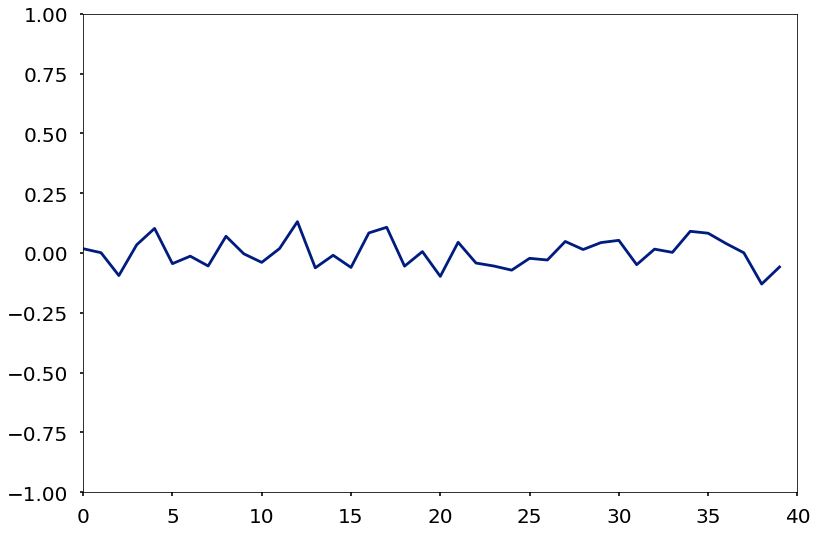

In [41]:
acf_filename = '/home/sangrey/Repositories/DirichletProcessMixture/doc/figures/alpha_series_acorr1.tmp.png'
acf_fig = plt.figure()
acf_ax = acf_fig.add_subplot(111)
acf_ax.plot(acf(pit1)[1:])
acf_ax.set_ylim([-1,1])
for label in acf_ax.get_xticklabels():
    label.set_fontsize(20)
for label in acf_ax.get_yticklabels():
    label.set_fontsize(20)
acf_ax.set_xlim([0, 40])
acf_fig.savefig(acf_filename, bbox_inches='tight', pad_inches=0)